In [720]:
import pandas as pd
import numpy as np

# loading in dfs and printing for visualization purposes
sales_df = pd.read_csv("./data/vgsales.csv")
critic_df = pd.read_csv("./data/games-data.csv")

print("SALES DF:")
print(sales_df.head())

print("SALES COLUMNS:")
print(sales_df.columns)

print("CRITIC DF:")
print(critic_df.head())

print("CRITIC COLUMNS")
print(critic_df.columns)

SALES DF:
   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  
SALES COLUMNS:
Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],


In [721]:
# CLEANING SALES_DF

# dropping the columns for the following reasons:
# Rank: games on the same platform later get aggregated but also Rank is very dependent on other 
# games at the time, making it a somewhat unhelpful parameter for ML
# Publisher: less helpful than Developer and it's unclear what the original dataset author meant by "publisher"
# Sales: All dropped as they interfere with predicting the target variable (global_sales)
sales_clean = sales_df.drop(['Rank', 'Publisher', 'NA_Sales', 'JP_Sales', 'EU_Sales', 'Other_Sales'], axis=1)
sales_clean.columns = sales_clean.columns.str.lower()

print(sales_clean.columns)

# standardizing the titles of video games in preparation for merging with the other df
sales_clean['name'] = sales_clean['name'].str.strip().str.lower()

# using minecraft as a benchmarker
print(sales_clean.head())
print(sales_clean[sales_clean['name'] == 'minecraft'])

# creating a column marking the earliest year of release
sales_first_release = sales_clean.groupby('name')['year'].min().reset_index(name='first_release')
sales_clean = sales_clean.merge(sales_first_release, on='name')

# drop all instances of the game that were released after 1 year of initial release
# this avoids bias towards extra ports of the game 
# ex: Minecraft on WiiU will probably do well because Minecraft on Xbox did well. This doesn't mean
# games on WiiU necessarily do better and shouldn't be used in the model.
sales_clean = sales_clean[sales_clean['year'] <= sales_clean['first_release'] + 1]

# aggregate all instances of a game now that you only have initial releases  
sales_clean = sales_clean.groupby('name', as_index=False, sort=False).agg({
    'platform': set, 
    'year': 'min', 
    'genre': set, 
    'global_sales': 'sum'})

print(sales_clean.head())
print(sales_clean[sales_clean['name'] == 'minecraft'])

Index(['name', 'platform', 'year', 'genre', 'global_sales'], dtype='object')
                       name platform    year         genre  global_sales
0                wii sports      Wii  2006.0        Sports         82.74
1         super mario bros.      NES  1985.0      Platform         40.24
2            mario kart wii      Wii  2008.0        Racing         35.82
3         wii sports resort      Wii  2009.0        Sports         33.00
4  pokemon red/pokemon blue       GB  1996.0  Role-Playing         31.37
           name platform    year genre  global_sales
72    minecraft     X360  2013.0  Misc          9.20
168   minecraft      PS3  2014.0  Misc          5.42
297   minecraft      PS4  2014.0  Misc          4.02
643   minecraft     XOne  2014.0  Misc          2.41
713   minecraft      PSV  2014.0  Misc          2.25
4513  minecraft     WiiU  2016.0  Misc          0.43
                       name platform    year           genre  global_sales
0                wii sports    {Wii}  2

In [722]:
# CLEANING CRITICS DF

critics_clean = critic_df.copy()

# converting column names to lowercase and changing spaces to _
critics_clean.columns = critics_clean.columns.str.lower()
critics_clean.columns = (
    critics_clean.columns.str.strip().str.lower().str.replace(' ', '_')
)

# cleaning up the players column into 4 categories: unknown, single, two, multi
critics_clean['players'] = critics_clean['players'].apply(
    lambda x: (
        "unknown" if pd.isna(x) or str(x).strip() == "No info"
        else "single" if str(x).strip() in {"1 Player", "No Online Multiplayer"}
        else "two" if str(x).strip() in {"1-2", "2", "2  Online"}
        else "multi"
    )
)

# cleaning platform column to match the other dataset
critics_clean['platform'] = critics_clean['platform'].apply(
    lambda x: (
        "DC" if str(x) == "Dreamcast"
        else "GBA" if str(x) == "GameBoyAdvance"
        else "GC" if str(x) == "GameCube"
        else "N64" if str(x) == "Nintendo64"
        else "PS" if str(x) == "PlayStation"
        else "PS2" if str(x) == "PlayStation2"
        else "PS3" if str(x) == "PlayStation3"
        else "PS4" if str(x) == "PlayStation4"
        else "PSV" if str(x) == "PlayStationVita"
        else "XB" if str(x) == "Xbox"
        else "X360" if str(x) == "Xbox360"
        else "XOne" if str(x) == "XboxOne"
        else str(x)
    )
)

# convert the release date to a release year
# although date would be helpful informaiton, we need to aggregate platform releases anyway
critics_clean['year'] = pd.to_datetime(critics_clean['r-date'], format='%B %d, %Y').dt.year
critics_clean = critics_clean.drop(['r-date'], axis=1)

print(critics_clean.columns)
print(critics_clean.head())

# standardizing the titles of video games in preparation for merging with the other df
critics_clean['name'] = critics_clean['name'].str.strip().str.lower()

# using minecraft as a benchmarker
print(critics_clean[critics_clean['name'] == 'minecraft'])

# creating a column marking the earliest year of release
critics_first_release = critics_clean.groupby('name')['year'].min().reset_index(name='first_release')
critics_clean = critics_clean.merge(critics_first_release, on='name')

# drop all instances of the game that were released after 1 year of initial release
critics_clean = critics_clean[critics_clean['year'] <= critics_clean['first_release'] + 1]

# change 'tbd' values to NaN
critics_clean['user_score'] = critics_clean['user_score'].astype(str).str.strip().replace({'tbd': np.nan})
critics_clean['user_score'] = pd.to_numeric(critics_clean['user_score'])

# aggregate all instances of a game now that you only have initial releases  
critics_clean = critics_clean.groupby('name', as_index=False, sort=False).agg({
    'platform': set, 
    'year': 'min', 
    'developer': lambda s: {
        val
        for devs in s
        for val in devs.split(',')
    },
    'genre': lambda s: {
        val
        for genres in s
        for val in genres.split(',')
    },
    'players': 'first',
    'score': 'mean', 
    'user_score': 'mean', 
    'critics': 'mean', 
    'users': 'mean'})

print(critics_clean.head())
print(critics_clean[critics_clean['name'] == 'minecraft'])

Index(['name', 'platform', 'score', 'user_score', 'developer', 'genre',
       'players', 'critics', 'users', 'year'],
      dtype='object')
                                   name platform  score user_score  \
0  The Legend of Zelda: Ocarina of Time      N64     99        9.1   
1              Tony Hawk's Pro Skater 2       PS     98        7.4   
2                   Grand Theft Auto IV      PS3     98        7.6   
3                           SoulCalibur       DC     98        8.5   
4                   Grand Theft Auto IV     X360     98        7.9   

                developer                                      genre players  \
0                Nintendo                   Action Adventure,Fantasy  single   
1  NeversoftEntertainment           Sports,Alternative,Skateboarding     two   
2           RockstarNorth  Action Adventure,Modern,Modern,Open-World  single   
3                   Namco                         Action,Fighting,3D     two   
4           RockstarNorth  Action Adve

In [723]:
# MERGING DATASETS

vg_df = sales_clean.merge(critics_clean, how='left', on='name')

print(vg_df.columns)
print(vg_df[vg_df['name'] == 'minecraft'])

# the code operates on the basis that the right-hand dataset is all filled out
if pd.isna(vg_df['platform_x']).any():
    raise ValueError("Found missing values in platform_x.")

if pd.isna(vg_df['year_x']).any():
    raise ValueError("Found missing values in year_x.")

if pd.isna(vg_df['genre_x']).any():
    raise ValueError("Found missing values in genre_x.")

# creating a column that indicates which of x or y we should choose
# if the datasets have entries from within a year of each other, they are considered "equal" and data should be merged
# if one dataset is earlier than the other, use the data from that one
vg_df['year_choice'] = vg_df.apply(
    lambda row: (
        'x' if pd.isna(row['year_y'])
        else 'equal' if abs(row['year_x'] - row['year_y']) <= 1
        else 'x' if row['year_x'] < row['year_y']
        else 'y'
    ),
    axis=1
)

# combining platforms
vg_df['platform'] = vg_df.apply(
    lambda row: 
        (row['platform_x'] | (row['platform_y'] if pd.notna(row['platform_y']) else set())) if row['year_choice'] == 'equal'
        else row['platform_x'] if row['year_choice'] == 'x'
        else row['platform_y'],
    axis=1
)
vg_df.drop(['platform_x', 'platform_y'], axis=1, inplace=True)

# combining genres
vg_df['genre'] = vg_df.apply(
    lambda row: 
        ((row['genre_x'] if 'Misc' not in row['genre_x'] else set()) | (row['genre_y'] if pd.notna(row['genre_y']) else set())) if row['year_choice'] == 'equal'
        else row['genre_x'] if row['year_choice'] == 'x'
        else row['genre_y'],
    axis=1
)
vg_df.drop(['genre_x', 'genre_y'], axis=1, inplace=True)

# finally combine years, take the minimum if they were considered equal
vg_df['year'] = vg_df.apply(
    lambda row: 
        min(row['year_x'], row['year_y']) if row['year_choice'] == 'equal'
        else row['year_x'] if row['year_choice'] == 'x'
        else row['year_y'],
    axis=1
).astype('Int64')
vg_df.drop(['year_x', 'year_y', 'year_choice'], axis=1, inplace=True)

print(vg_df.columns)
print(vg_df[vg_df['name'] == 'minecraft'])

print("TOTAL VALUES:")
print(vg_df['name'].nunique())

print("Number values without metacritic scores:")
print(pd.isna(vg_df['score']).sum())

print(vg_df.head())

Index(['name', 'platform_x', 'year_x', 'genre_x', 'global_sales', 'platform_y',
       'year_y', 'developer', 'genre_y', 'players', 'score', 'user_score',
       'critics', 'users'],
      dtype='object')
         name                   platform_x  year_x genre_x  global_sales  \
63  minecraft  {XOne, PS4, PSV, X360, PS3}  2013.0  {Misc}          23.3   

    platform_y  year_y              developer  \
63  {X360, PC}  2011.0  {4JStudios, MojangAB}   

                                              genre_y players  score  \
63  {Adventure, Fantasy, Action Adventure, 3D, San...   multi   87.5   

    user_score  critics   users  
63         7.6     48.0  3179.5  
Index(['name', 'global_sales', 'developer', 'players', 'score', 'user_score',
       'critics', 'users', 'platform', 'genre', 'year'],
      dtype='object')
         name  global_sales              developer players  score  user_score  \
63  minecraft          23.3  {4JStudios, MojangAB}   multi   87.5         7.6   

    critic

In [724]:
# PERFORMING EDA

print("ROWS, COLUMNS:", vg_df.shape)
print(vg_df.columns)
print(vg_df.head())

print("COLUMN TYPES: ", vg_df.dtypes)

ROWS, COLUMNS: (11360, 11)
Index(['name', 'global_sales', 'developer', 'players', 'score', 'user_score',
       'critics', 'users', 'platform', 'genre', 'year'],
      dtype='object')
                       name  global_sales   developer players  score  \
0                wii sports         82.74  {Nintendo}  single   76.0   
1         super mario bros.         40.24         NaN     NaN    NaN   
2            mario kart wii         35.82  {Nintendo}   multi   82.0   
3         wii sports resort         33.00  {Nintendo}   multi   80.0   
4  pokemon red/pokemon blue         31.37         NaN     NaN    NaN   

   user_score  critics  users platform  \
0         8.0     51.0  429.0    {Wii}   
1         NaN      NaN    NaN    {NES}   
2         8.4     73.0  982.0    {Wii}   
3         8.1     73.0  266.0    {Wii}   
4         NaN      NaN    NaN     {GB}   

                                         genre  year  
0     {General, Individual, Athletics, Sports}  2006  
1                   

In [725]:
# duplicates check
hashable_cols = ['name', 'global_sales', 'players', 'score', 'user_score', 'critics', 'users', 'year']
duplicates = vg_df[hashable_cols].duplicated()
if (duplicates.any()):
    print("DUPLICATES FOUND.")
    vg_df = vg_df.drop_duplicates(subset=hashable_cols, keep='first')
else:
    print("No duplicates.")

No duplicates.


In [726]:

# general value and type checks for each column
if (pd.isna(vg_df['global_sales']).any()):
    raise ValueError("Missing global sales figure for some games.")
      
if not (vg_df['name'].apply(lambda x: isinstance(x, str)).all()):
    raise ValueError("Invalid names.")

if not (vg_df['developer'].apply(lambda s: True if pd.isna(s) else all(isinstance(x, str) for x in s)).all()):
    raise ValueError("Invalid developer names.")

if not (vg_df['players'].apply(lambda x: True if pd.isna(x) else isinstance(x, str) and x in ['unknown', 'single', 'two', 'multi']).all()):
    raise ValueError("Invalid player values.")

if not (vg_df['score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0 and x <= 100).all()):
    raise ValueError("Invalid score.")

if not (vg_df['user_score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0 and x <= 10).all()):
    raise ValueError("Invalid user score.")

if not (vg_df['critics'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0).all()):
    raise ValueError("Invalid number of critics.")

if not (vg_df['score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0).all()):
    raise ValueError("Invalid score.")

if not (vg_df['platform'].apply(lambda s: all(isinstance(x, str) for x in s)).all()):
    raise ValueError("Invalid platform names.")

if not (vg_df['year'].apply(lambda x: isinstance(x, int) and x >= 0 and x <= 2025).all()):
    raise ValueError("Invalid score.")


In [727]:
# checking for missing values
missing = vg_df.isnull().sum()
percent_missing = missing.sum() / vg_df.size
print("NUMBER MISSING: " + str(missing.sum()))
print("PERCENT MISSING: " + str(percent_missing.sum()))
print("VALUES MISSING: ")
print(missing)

NUMBER MISSING: 39972
PERCENT MISSING: 0.3198783610755442
VALUES MISSING: 
name               0
global_sales       0
developer       6612
players         6612
score           6612
user_score      6912
critics         6612
users           6612
platform           0
genre              0
year               0
dtype: int64


In [728]:
# use .describe() because the value is continuous
print(vg_df["global_sales"].describe())

count    11360.000000
mean         0.757985
std          2.194553
min          0.010000
25%          0.060000
50%          0.190000
75%          0.600000
max         82.740000
Name: global_sales, dtype: float64


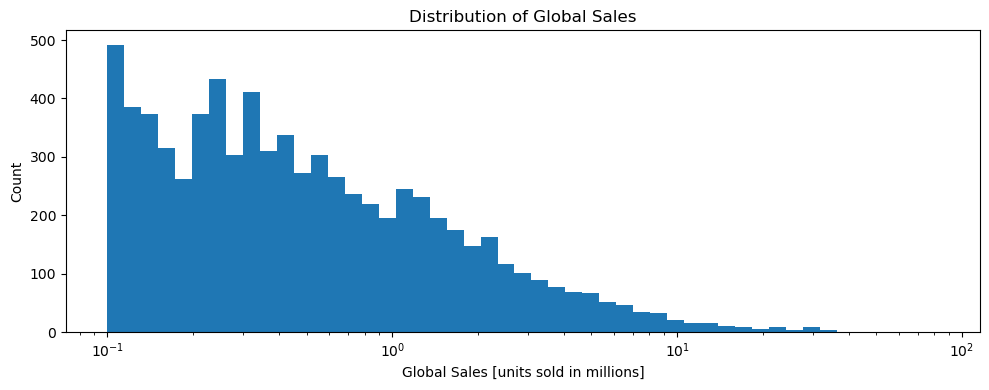

Graph displaying distribution of global sales of copies of the game.


In [729]:
from matplotlib import pylab as plt

# visualizing the target variable, global_sales
plt.figure(figsize=(10, 4))

vg_df['global_sales'].plot.hist(bins = np.logspace(np.log10(0.1), np.log10(np.max(vg_df['global_sales'])), 50))
plt.semilogx()
plt.xlabel('Global Sales [units sold in millions]')
plt.ylabel('Count')
plt.title("Distribution of Global Sales")
plt.tight_layout()
plt.show()

print("Graph displaying distribution of global sales of copies of the game.")

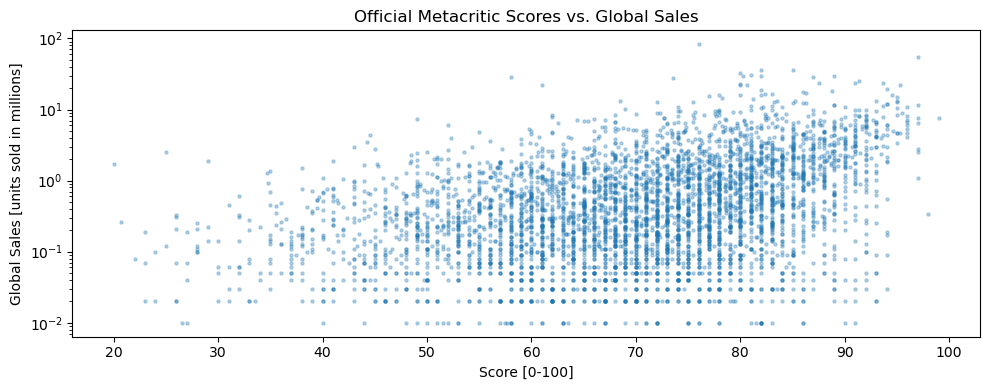

Graph displaying correlation between official Metacritic scores (0-100) vs. number of copies sold globally.
As you can see, there is a strong positive correlation.


In [730]:
vg_df.plot.scatter('score', 'global_sales',figsize=(10, 4),alpha=0.3,s=5)
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-100]")
plt.title("Official Metacritic Scores vs. Global Sales")
plt.tight_layout()
plt.show()

print("Graph displaying correlation between official Metacritic scores (0-100) vs. number of copies sold globally.")
print("As you can see, there is a strong positive correlation.")

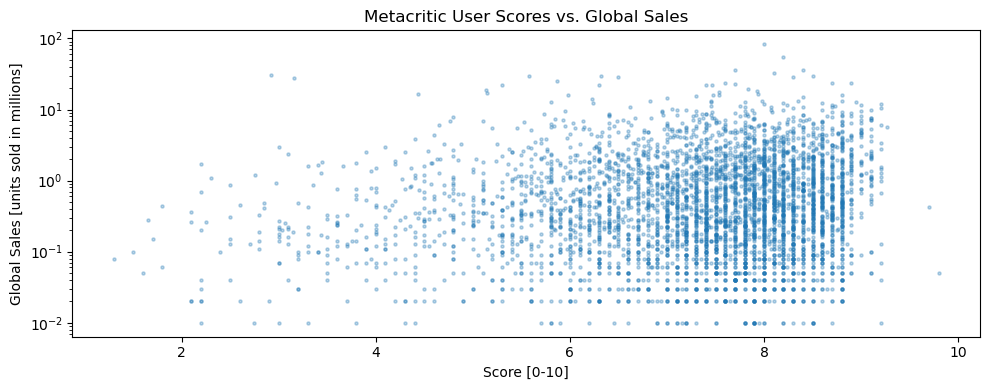

Graph displaying correlation between Metacritic's user scores (0-10) vs. number of copies sold globally.
There is still a positive correlation, but not as strong as with the official Metacritic scores.


In [731]:
vg_df.plot.scatter('user_score', 'global_sales',figsize=(10, 4),alpha=0.3,s=5)
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-10]")
plt.title("Metacritic User Scores vs. Global Sales")
plt.tight_layout()
plt.show()

print("Graph displaying correlation between Metacritic's user scores (0-10) vs. number of copies sold globally.")
print("There is still a positive correlation, but not as strong as with the official Metacritic scores.")

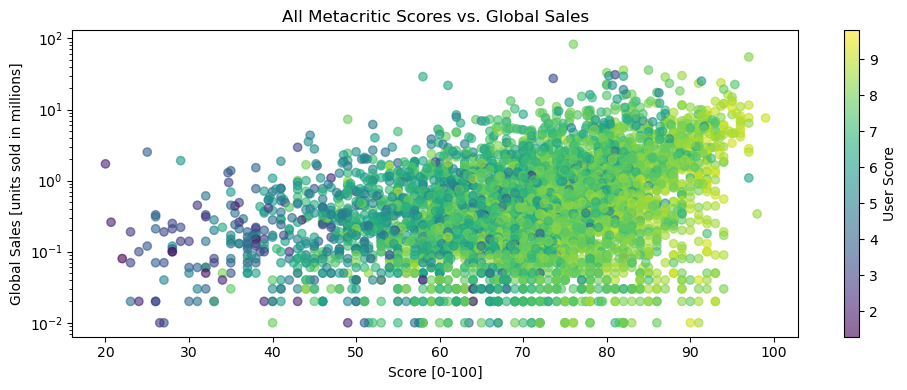

Graph displaying relationship between official Metacritic scores and Metacritic's user scores vs. number of copies sold globally.
There is some discrepancy with occasional games performing badly with users but selling well.
There is still a general positive correlation, and games that do well on Metacritic tend to do well with users.


In [732]:
plt.figure(figsize=(10, 4))

plt.scatter(
    vg_df['score'],
    vg_df['global_sales'],
    c=vg_df['user_score'], cmap='viridis', alpha=0.6
)
plt.colorbar(label='User Score')
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-100]")
plt.title("All Metacritic Scores vs. Global Sales")
plt.tight_layout()
plt.show()

print("Graph displaying relationship between official Metacritic scores and Metacritic's user scores vs. number of copies sold globally.")
print("There is some discrepancy with occasional games performing badly with users but selling well.")
print("There is still a general positive correlation, and games that do well on Metacritic tend to do well with users.")

year
2004    520
2005    628
2006    738
2007    840
2008    977
2009    952
2010    856
2011    749
2012    404
2013    298
2014    282
2015    320
2016    185
2017      2
2020      1
Name: count, dtype: Int64


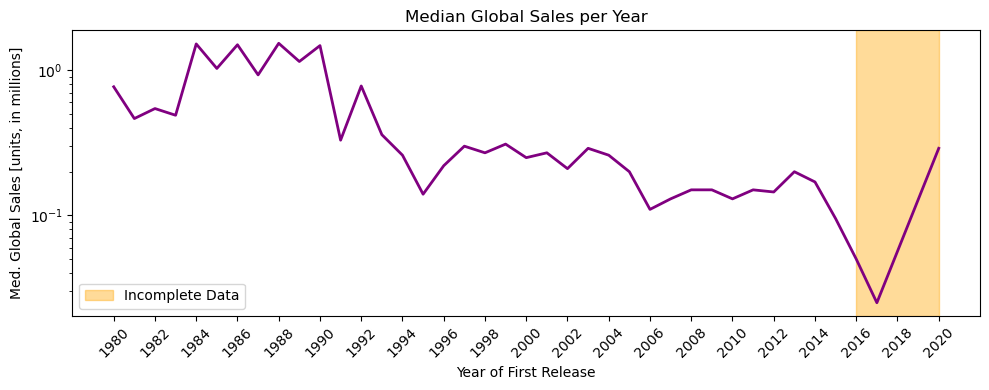

Graph displaying median global sales over the years. There is a general downward trend.
The area in orange is marked as such as there is very little data for 2017 and 2020.


In [733]:
print(vg_df['year'].value_counts().sort_index().tail(15))

yearly = vg_df.groupby('year')['global_sales'].median().reset_index()

plt.figure(figsize=(10,4))
plt.plot(yearly['year'], yearly['global_sales'], color='purple', linewidth=2)
plt.semilogy()
plt.xticks(np.arange(1980, 2021, 2))
plt.xticks(rotation=45)
plt.axvspan(2016, 2020, color='orange', alpha=0.4, label='Incomplete Data')
plt.legend()
plt.xlabel('Year of First Release')
plt.ylabel('Med. Global Sales [units, in millions]')
plt.title('Median Global Sales per Year')
plt.tight_layout()
plt.show()

print("Graph displaying median global sales over the years. There is a general downward trend.")
print("The area in orange is marked as such as there is very little data for 2017 and 2020.")

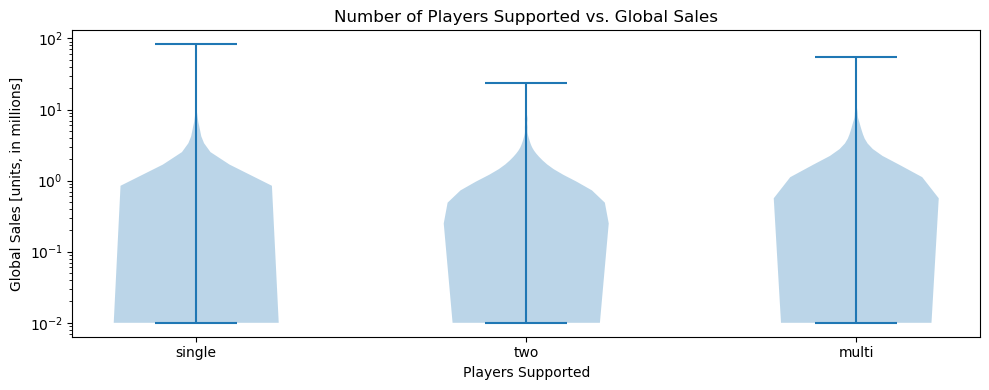

Graph displaying relationship between number of players a game supports vs. global sales.
There is perhaps a slight positive trend for multiplayer games, but overall not a strong correlation.


In [734]:
dataset = [vg_df[vg_df['players'] == 'single']['global_sales'].values,
           vg_df[vg_df['players'] == 'two']['global_sales'].values,
           vg_df[vg_df['players'] == 'multi']['global_sales'].values]

plt.figure(figsize=(10,4))

plt.violinplot(dataset = dataset)
plt.semilogy()
plt.xticks([1, 2, 3],['single', 'two', 'multi'])
plt.xlabel("Players Supported")
plt.ylabel('Global Sales [units, in millions]')
plt.title("Number of Players Supported vs. Global Sales")
plt.tight_layout()
plt.show()

print("Graph displaying relationship between number of players a game supports vs. global sales.")
print("There is perhaps a slight positive trend for multiplayer games, but overall not a strong correlation.")

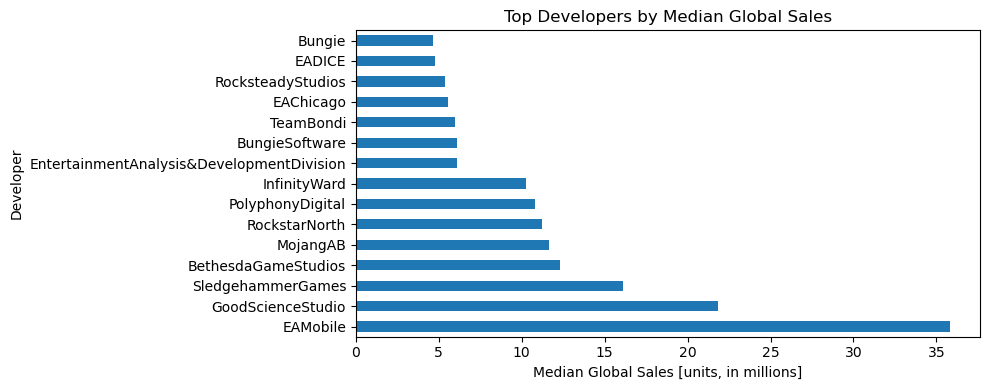

Graph displaying the top 15 developers by their median global sales.


In [735]:
# to accurately graph developers, we must first reshape the data to separate each developer
dev_sales_weighted = vg_df.copy()

# this creates a column that distrubtes copies sold evenly over the developers
# if a game with 2 developers sold 20 million copies, then each developer gets 10 million copies to their credit
dev_sales_weighted['num_devs'] = dev_sales_weighted['developer'].apply(lambda x: len(x) if not pd.isna(x) else 0)
dev_sales_weighted['sales_per_dev'] = dev_sales_weighted['global_sales'] / dev_sales_weighted['num_devs']
vg_df_exploded = dev_sales_weighted.explode('developer').copy()
top_dev_sales = vg_df_exploded.groupby('developer')['sales_per_dev'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Developer')
plt.title('Top Developers by Median Global Sales')
plt.tight_layout()
plt.show()

print("Graph displaying the top 15 developers by their median global sales.")

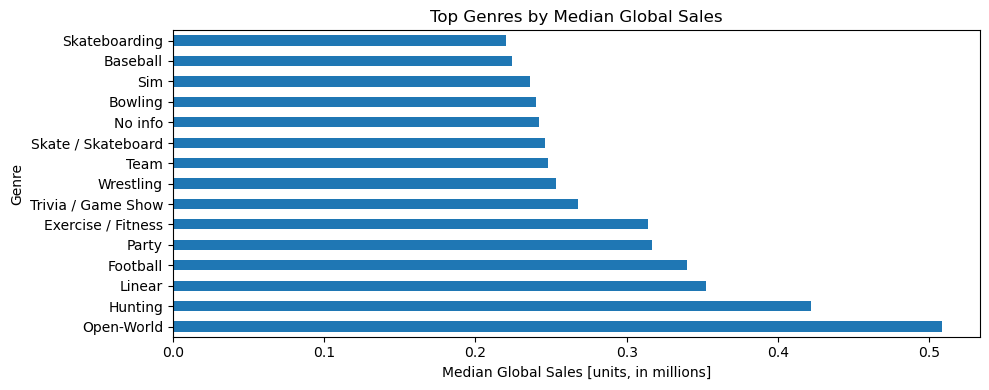

Graph displaying the top 15 game genres by their median global sales.


In [736]:
# performing same logic as above for genres
genre_sales_weighted = vg_df.copy()

genre_sales_weighted['num_genres'] = genre_sales_weighted['genre'].apply(lambda x: len(x) if not pd.isna(x) else 0)
genre_sales_weighted['sales_per_genre'] = genre_sales_weighted['global_sales'] / genre_sales_weighted['num_genres']
vg_df_exploded = genre_sales_weighted.explode('genre').copy()
top_dev_sales = vg_df_exploded.groupby('genre')['sales_per_genre'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Genre')
plt.title('Top Genres by Median Global Sales')
plt.tight_layout()
plt.show()

print("Graph displaying the top 15 game genres by their median global sales.")

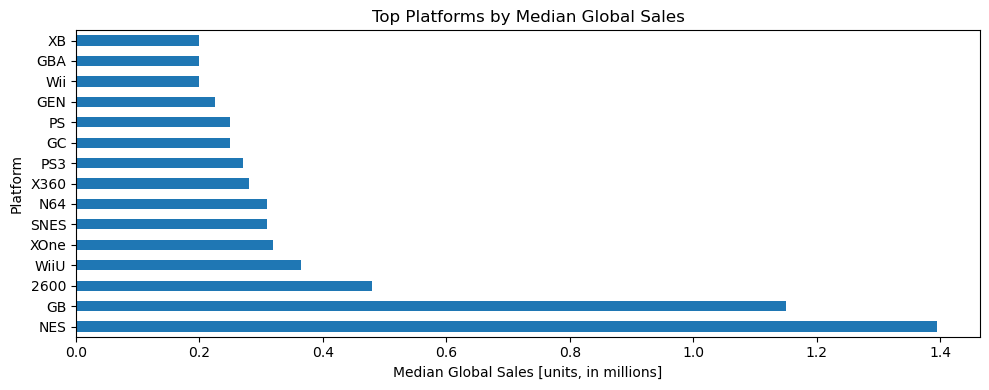

Graph displaying the top 15 gaming platforms by their median global sales.


In [737]:
# performing same logic as above for platforms
platform_sales_weighted = vg_df.copy()

platform_sales_weighted['num_platforms'] = platform_sales_weighted['platform'].apply(lambda x: len(x) if not pd.isna(x) else 0)
platform_sales_weighted['sales_per_platform'] = platform_sales_weighted['global_sales'] / platform_sales_weighted['num_platforms']
vg_df_exploded = platform_sales_weighted.explode('platform').copy()
top_dev_sales = vg_df_exploded.groupby('platform')['sales_per_platform'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Platform')
plt.title('Top Platforms by Median Global Sales')
plt.tight_layout()
plt.show()

print("Graph displaying the top 15 gaming platforms by their median global sales.")

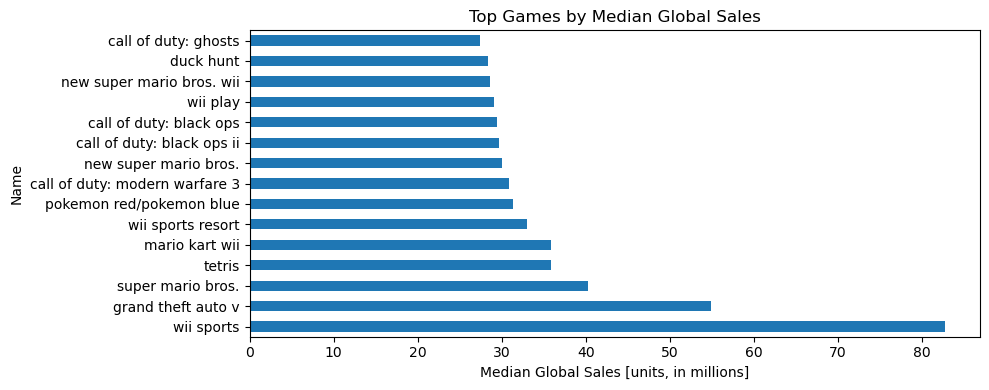

Graph showing top game titles by median global sales.


In [738]:
top_games = vg_df.groupby('name')['global_sales'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_games.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Name')
plt.title('Top Games by Median Global Sales')
plt.tight_layout()
plt.show()

print("Graph showing top game titles by median global sales.")

In [739]:
# lists of features
continuous_ftrs = ['score', 'user_score', 'critics', 'users', 'year']
ordinal_ftrs = ['players'] 
ordinal_cats = [['unknown', 'single', 'two', 'multi']]
multi_label = ['developer', 'platform', 'genre']

# sort by year to get in chronological order
vg_df_sorted = vg_df.sort_values('year').reset_index(drop=True)
vg_df_sorted.drop(['name'], axis=1, inplace=True)

# split out target variable
y = vg_df_sorted['global_sales']
X = vg_df_sorted.loc[:, vg_df_sorted.columns != 'global_sales']

# prepping the multi-label features for the binarizer
for col in multi_label:
    X[col] = X[col].apply(lambda x: [] if pd.isna(x) else list(x))

# perform a basic chronological split for train, test, val
n = len(vg_df_sorted)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]


/var/folders/v8/_jhww54x34gg2zggklfkh9tr0000gn/T/ipykernel_88597/484040168.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].apply(lambda x: [] if pd.isna(x) else list(x))


In [740]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("BEFORE PROCESSING: ")
print(X_train.head())

mlb_X_train = X_train.copy()
mlb_X_test = X_test.copy()
mlb_X_val = X_val.copy()

for col in multi_label:
    mlb = MultiLabelBinarizer()

    train_mlb = mlb.fit_transform(mlb_X_train[col])
    test_mlb = mlb.transform(mlb_X_test[col])
    val_mlb = mlb.transform(mlb_X_val[col])

    col_name = [f"{col}_{label}" for label in mlb.classes_]

    train_mlb_df = pd.DataFrame(train_mlb, columns=col_name, index=mlb_X_train.index)
    test_mlb_df = pd.DataFrame(test_mlb, columns=col_name, index=mlb_X_test.index)
    val_mlb_df = pd.DataFrame(val_mlb, columns=col_name, index=mlb_X_val.index)

    mlb_X_train.drop(col, axis=1, inplace=True)
    mlb_X_train = pd.concat([mlb_X_train, train_mlb_df], axis=1)

    mlb_X_test.drop(col, axis=1, inplace=True)
    mlb_X_test = pd.concat([mlb_X_test, test_mlb_df], axis=1)

    mlb_X_val.drop(col, axis=1, inplace=True)
    mlb_X_val = pd.concat([mlb_X_val, val_mlb_df], axis=1)

# preprocessor pipeline: calling standard scaling on continuous features, ordinal encoding for players, then MLB
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), continuous_ftrs),
        ('ord', OrdinalEncoder(categories = ordinal_cats, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_ftrs),
    ],
    remainder='passthrough')
clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prepro = clf.fit_transform(mlb_X_train)
X_test_prepro = clf.transform(mlb_X_test)
X_val_prepro = clf.transform(mlb_X_val)

# all_columns = np.concatenate([clf.get_feature_names_out(), multi_label])

X_train_df = pd.DataFrame(data=X_train_prepro, columns=clf.get_feature_names_out())
X_test_df = pd.DataFrame(data=X_test_prepro, columns=clf.get_feature_names_out())
X_val_df = pd.DataFrame(data=X_val_prepro, columns=clf.get_feature_names_out())

print(X_train_df.head())
print(X_test_df.head())
print(X_val_df.head())

BEFORE PROCESSING: 
                                           developer players  score  \
0  [7Studios, InevitableEntertainment, OutLookEnt...     two  61.25   
1                                                 []     NaN    NaN   
2                                                 []     NaN    NaN   
3                                   [StainlessGames]     two  63.00   
4                                                 []     NaN    NaN   

   user_score  critics  users platform      genre  year  
0        7.45    16.25    3.0   [2600]     [Misc]  1980  
1         NaN      NaN    NaN   [2600]   [Sports]  1980  
2         NaN      NaN    NaN   [2600]     [Misc]  1980  
3         NaN    15.00    0.0   [2600]  [Shooter]  1980  
4         NaN      NaN    NaN   [2600]     [Misc]  1980  


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['11bitstudios', '2KAustralia', '2KCzech', '2KGames', '343Industries', '3DRealms', '4AGames', '7thChord', 'AirtightGames', 'AksysGames', 'AmanitaDesign', 'ApolloSoft', 'AquaPlus', 'ArmatureStudio', 'Artdink', 'Arzest', 'AtomicGames', 'AvalonStyle', 'B.B.Studio', 'BehaviourInteractive', 'BigRedButtonEntertainment', 'CIGames', 'CUBETYPE', 'Camouflaj', 'CapcomVancouver', 'CarbineStudios', 'Chime', 'CodeMysticsInc.', 'CodemastersBirmingham', 'CoffeeStainStudios', 'ColossalOrder', 'CompulsionGames', 'CranberryProduction', "Crispy's", 'CyanideStudios', 'DONTNODEntertainment', 'DaedalicEntertainment', 'DangerClose', 'DeepSilverDambusterStudios', 'DevilsDetails', 'DingoInc.', 'DinoDini', 'DoubleEleven', 'Dracue', 'DusenberryMartinRacing', 'EAVancouver', 'EidosMontreal', 'EntertainmentAnalysis&DevelopmentDivision', 'EugenSystems', 'ExperienceInc.', 'FatsharkAB', 'Feliste

   std__score  std__user_score  std__critics  std__users  std__year  \
0   -0.613495         0.010261     -0.604099   -0.264287  -4.312633   
1         NaN              NaN           NaN         NaN  -4.312633   
2         NaN              NaN           NaN         NaN  -4.312633   
3   -0.484156              NaN     -0.684512   -0.271319  -4.312633   
4         NaN              NaN           NaN         NaN  -4.312633   

   ord__players  remainder__developer_10tacleStudios  remainder__developer_1C  \
0           2.0                                  0.0                      0.0   
1          -1.0                                  0.0                      0.0   
2          -1.0                                  0.0                      0.0   
3           2.0                                  0.0                      0.0   
4          -1.0                                  0.0                      0.0   

   remainder__developer_1C:MaddoxGames  remainder__developer_1CEntertainment  \
0     